## Collaborative Filtering on MovieLens 10M dataset
Authors: (USRMODL S12)
- Christopher Lim
- Kyle Kenneth Chua
- Jethro Tsai

## Importing the Libraries

Loading the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Loading the data preparation and model evaluation libraries

In [2]:
from sklearn.model_selection import train_test_split

from mse import mse

## Importing the Datasets

In [3]:
movies = pd.read_csv('./movie.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('./rating.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [5]:
df = movies.merge(ratings, how="left", on="movieId")
df.head()

del movies
del ratings

## Exploratory Data Analysis

### Columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000797 entries, 0 to 20000796
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     float64
 4   rating     float64
 5   timestamp  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 1.0+ GB


In [7]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
mean_num_ratings = df.groupby('userId').count()['movieId'].mean()

print('Number of users:', n_users)   # 5000
print('Number of movies:', n_movies) # 1000
print('Number of ratings:', len(df))
print('Average number of ratings per user:', mean_num_ratings)

Number of users: 138493
Number of movies: 27278
Number of ratings: 20000797
Average number of ratings per user: 144.4135299257002


<AxesSubplot:xlabel='userId'>

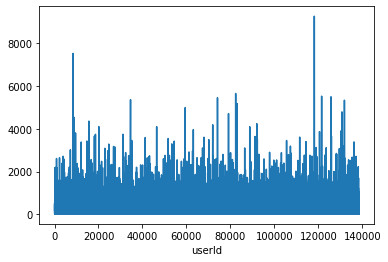

In [8]:
df.groupby('userId').count()['movieId'].plot()

<AxesSubplot:xlabel='movieId'>

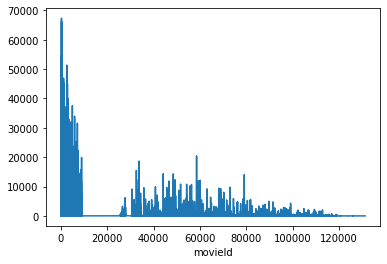

In [9]:
df.groupby('movieId').count()['userId'].plot()

In [10]:
print('Min Rating:', df['rating'].min())
print('Max Rating:', df['rating'].max())

Min Rating: 0.5
Max Rating: 5.0


## Data Preprocessing

### Drop missing user ids

In [11]:
df = df.dropna(subset=["userId"], axis=0)
len(df)

20000263

### Removes `genres`, `timestamp`, and `title` column

In [12]:
# Remove column name 'genres', 'timestamp' and 'title'
df = df.drop(['genres', 'timestamp', 'title'], axis=1)
df['userId'] = df['userId'].astype(int)
df.head()

,movieId,userId,rating
0,1,3,4.0
1,1,6,5.0
2,1,8,4.0
3,1,10,4.0
4,1,11,4.5


### Filter to top 1,000 movies and top 1,000 users

In [13]:
n_users = 1000
n_movies = 1000

In [14]:
titles = df['movieId'].value_counts().head(n_movies).index # top  1,000 most-rated movies
users = df['userId'].value_counts().head(n_users).index  # top 1,000 users with the most number of ratings

top_df = df[(df['movieId'].isin(titles) & df['userId'].isin(users))]
top_df.head()

,movieId,userId,rating
56,1,156,5.0
71,1,208,4.0
123,1,359,5.0
186,1,572,5.0
190,1,586,2.5


In [15]:
print('Number of users:', top_df['userId'].nunique())
print('Number of movies:', top_df['movieId'].nunique()) 
print('Number of ratings:', len(top_df))
print('Average number of ratings per user:', top_df.groupby('userId').count()['movieId'].mean())

Number of users: 1000
Number of movies: 1000
Number of ratings: 627078
Average number of ratings per user: 627.078


#### Convert table format into user-item matrix (utility matrix) format 

In [25]:
top_um= top_df.pivot_table(index=["userId"], columns=["movieId"], values="rating").to_numpy(dtype=np.float32, na_value=0)
sparsity = (1.0 - np.count_nonzero(top_um) / top_um.size) * 100

print('Shape:', top_um.shape)
print('Sparsity: %.2f%%' % sparsity)

Shape: (1000, 1000)
Sparsity: 37.29%


### Filter to top 1,000 movies and 1,000 random users

In [17]:
titles = df['movieId'].value_counts().head(n_movies).index # top  1,000 most-rated movies
users = df.groupby('userId').count().sample(n=n_users, random_state=0).index

random_df = df[df['movieId'].isin(titles)][df['userId'].isin(users)]
random_df.head()

del df

In [18]:
print('Number of users:', random_df['userId'].nunique())
print('Number of movies:', random_df['movieId'].nunique())
print('Number of ratings:', len(random_df))
print('Average number of ratings per user:', random_df.groupby('userId').count()['movieId'].mean())

Number of users: 1000
Number of movies: 1000
Number of ratings: 97366
Average number of ratings per user: 97.366


#### Convert table format into user-item matrix (utility matrix) format 

In [24]:
random_um= random_df.pivot_table(index=["userId"], columns=["movieId"], values="rating").to_numpy(dtype=np.float32, na_value=0)
sparsity = (1.0 - np.count_nonzero(random_um) / random_um.size) * 100

print('Shape:', random_um.shape)
print('Sparsity: %.2f%%' % sparsity)

Shape: (1000, 1000)
Sparsity: 90.26%


### Get MSE on avg rating per user and avg rating per movie

In [26]:
utility_matrices = [top_um, random_um]

for um in utility_matrices:
    average_rating_per_user = [np.mean(row[row > 0]) for row in um]
    print('MSE based on average user rating:', np.sum([np.sum(np.square(row[row > 0] - average_rating_per_user[i])) for i, row in enumerate(um)]) / len(um[um > 0]))
    
    average_rating_per_movie = [np.mean(column[column > 0]) for column in um.T]
    print('MSE based on average movie rating:', np.sum([np.sum(np.square(column[column > 0] - average_rating_per_user[i])) for i, column in enumerate(um.T)]) / len(um[um > 0]))
    
    print('Unique values:', np.unique(um))
    print('-' * 20)

MSE based on average user rating: 0.8692040703070432
MSE based on average movie rating: 1.184244324470002
Unique values: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
--------------------
MSE based on average user rating: 0.8742411846794569
MSE based on average movie rating: 1.2724553809851489
Unique values: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
--------------------


### Convert utility matrix ratings from 0 until 5 to -1 until 1 
[0] values means missing values to be converted to -1  
[0.5, 1, 1.5, 2] values means low ratings to be converted to 0 (labeled as bad ratings)  
[2.5, 3, 3.5, 4, 4.5, 5] values means high ratings to be converted to 1 (labeled as good ratings)

In [27]:
normalized_utility_matrices = []
for i, um in enumerate(utility_matrices):
    normalized_utility_matrices.append(um / 5)
    
    print(np.unique(normalized_utility_matrices[i]))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


## Models

### Matrix Factorization Models

#### Importing the Matrix Factorizatoin Model

In [35]:
from matrix_factorization import MF

#### Training

In [37]:
training_results = []
predictions = []

for i in range(len(utility_matrices)):
    # Initialize the Matrix Factorization model
    mf = MF(utility_matrices[i], 2, alpha=0.008, beta=0.002, iterations=50)
    
    # Trains the model
    training_result = mf.train()
    
    # Stores the final full matrix
    predictions.append(mf.full_matrix())
    
    # Stores the results
    training_results.append(training_result)

Epoch: 1 ; error = 0.6661
Epoch: 2 ; error = 0.6568
Epoch: 3 ; error = 0.6450
Epoch: 4 ; error = 0.6210
Epoch: 5 ; error = 0.6056
Epoch: 6 ; error = 0.5992
Epoch: 7 ; error = 0.5952
Epoch: 8 ; error = 0.5920
Epoch: 9 ; error = 0.5904
Epoch: 10 ; error = 0.5891
Epoch: 11 ; error = 0.5885
Epoch: 12 ; error = 0.5877
Epoch: 13 ; error = 0.5870
Epoch: 14 ; error = 0.5865
Epoch: 15 ; error = 0.5861
Epoch: 16 ; error = 0.5855
Epoch: 17 ; error = 0.5846
Epoch: 18 ; error = 0.5840
Epoch: 19 ; error = 0.5833
Epoch: 20 ; error = 0.5825
Epoch: 21 ; error = 0.5819
Epoch: 22 ; error = 0.5814
Epoch: 23 ; error = 0.5807
Epoch: 24 ; error = 0.5804
Epoch: 25 ; error = 0.5802
Epoch: 26 ; error = 0.5796
Epoch: 27 ; error = 0.5794
Epoch: 28 ; error = 0.5791
Epoch: 29 ; error = 0.5791
Epoch: 30 ; error = 0.5791
Epoch: 31 ; error = 0.5789
Epoch: 32 ; error = 0.5789
Epoch: 33 ; error = 0.5788
Epoch: 34 ; error = 0.5788
Epoch: 35 ; error = 0.5788
Epoch: 36 ; error = 0.5789
Epoch: 37 ; error = 0.5787
Epoch: 38 

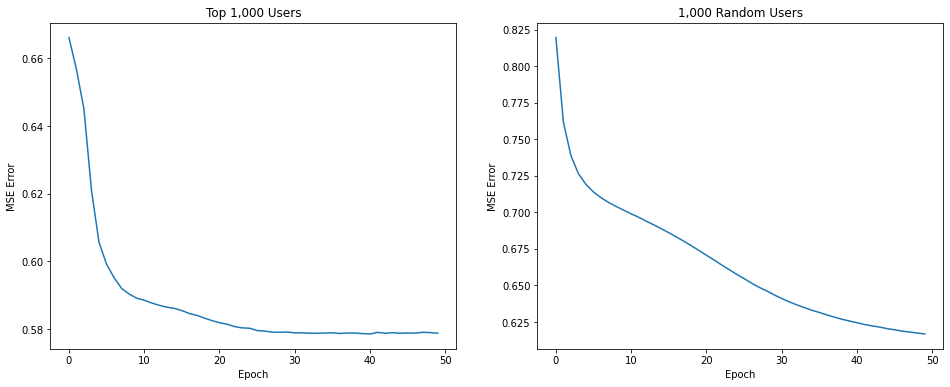

In [38]:
fig = plt.figure(figsize=(16, 6))
titles = ['Top 1,000 Users', '1,000 Random Users']

row = 1
col = 2

for i in range(len(utility_matrices)):
    # Adds a subplot at the 1st position
    fig.add_subplot(row, col, i + 1)
    pd.Series(training_results[i]).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("MSE Error")
    plt.title(titles[i])

plt.show()

#### TODO - randomly get a random row/column for each types of data and compare

### Random Boltzmann Machine Models
https://github.com/echen/restricted-boltzmann-machines

#### Importing the RBM Model

In [26]:
from rbm import RBM

Instructions for updating:
non-resource variables are not supported in the long term


#### Training the RBM Model

In [28]:
data = []

for um in normalized_utility_matrices:
    # Define the parameters of the RBMs we will train
    rbm=RBM(n_users, n_movies, learning_rate=0.01, epochs=1000, batch_size=200)
    
    # Trains the model
    training_result = rbm.train(um)
    
    output, predicted, _ = rbm.rbm_output(um)
    
    data.append({
        'model': rbm,
        'output': output,
        'predicted': predicted,
        'training_result': training_result
    })

Epoch: 0 ; reconstruction error: 0.966194
Epoch: 1 ; reconstruction error: 0.955088
Epoch: 2 ; reconstruction error: 0.956643
Epoch: 3 ; reconstruction error: 0.958166
Epoch: 4 ; reconstruction error: 0.960479
Epoch: 5 ; reconstruction error: 0.961828
Epoch: 6 ; reconstruction error: 0.963132
Epoch: 7 ; reconstruction error: 0.964680
Epoch: 8 ; reconstruction error: 0.964711
Epoch: 9 ; reconstruction error: 0.967344
Epoch: 10 ; reconstruction error: 0.968241
Epoch: 11 ; reconstruction error: 0.967675
Epoch: 12 ; reconstruction error: 0.967319
Epoch: 13 ; reconstruction error: 0.968308
Epoch: 14 ; reconstruction error: 0.968328
Epoch: 15 ; reconstruction error: 0.969061
Epoch: 16 ; reconstruction error: 0.971061
Epoch: 17 ; reconstruction error: 0.969984
Epoch: 18 ; reconstruction error: 0.969772
Epoch: 19 ; reconstruction error: 0.969277
Epoch: 20 ; reconstruction error: 0.970222
Epoch: 21 ; reconstruction error: 0.971348
Epoch: 22 ; reconstruction error: 0.970797
Epoch: 23 ; reconstru

KeyboardInterrupt: 

#### Visualization Errors

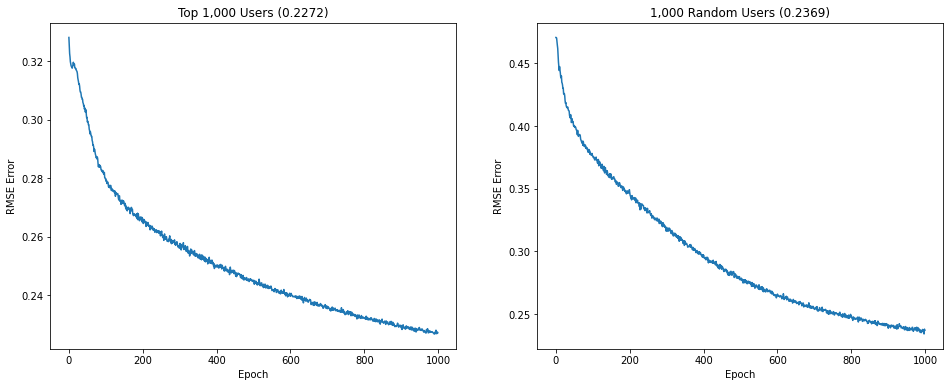

In [28]:
fig = plt.figure(figsize=(16, 6))
titles = ['Top 1,000 Users', '1,000 Random Users']

row = 1
col = 2

for i, d in enumerate(data):
    # Adds a subplot at the 1st position
    fig.add_subplot(row, col, i + 1)
    pd.Series(d['training_result']).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("RMSE Error")
    plt.title(titles[i] + (' (%.4f)' % (d['training_result'][-1])))

plt.show()

## Results

## Insights and Conclusions